<a href="https://colab.research.google.com/github/alexvaroz/ProjetoBR319/blob/master/Processamento_Vetores_Geo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook tem o objetivo de concentrar os códigos desenvolvidos para a manipulação dos arquivos `shapefile` utilizados no projeto **"Caracterização do uso e ocupação do solo na área de influência da BR-319"**.

Abaixo, algumas referências consultadas:

https://towardsdatascience.com/looking-for-patterns-in-satellite-image-time-series-with-python-de097f4065d7

https://towardsdatascience.com/automating-gis-and-remote-sensing-workflows-with-open-python-libraries-e71dd6b049ee

https://towardsdatascience.com/reading-and-visualizing-geotiff-images-with-python-8dcca7a74510

In [1]:
# Instalação das bibliotecas necessárias
!pip install geemap -q
!pip install earthengine-api -q
!pip install geopandas -q
!pip install earthpy -q 
!pip install pygeos -q

     |████████████████████████████████| 2.1 MB 3.8 MB/s 
     |████████████████████████████████| 1.3 MB 42.7 MB/s 
     |████████████████████████████████| 3.7 MB 43.8 MB/s 
     |████████████████████████████████| 3.5 MB 39.6 MB/s 
     |████████████████████████████████| 198 kB 49.4 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 98 kB 7.0 MB/s 
     |████████████████████████████████| 130 kB 25.3 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 99 kB 4.5 MB/s 
     |████████████████████████████████| 1.2 MB 43.1 MB/s 
     |████████████████████████████████| 128 kB 49.5 MB/s 
     |████████████████████████████████| 1.6 MB 22.4 MB/s 
     |████████████████████████████████| 79 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 3.8 MB/s 
     |████████████████████████████████| 16.6 MB 53.6 MB/s 
     |████████████████████████████████| 7.8 MB 50.0 MB/s 
     |███████████████████

In [2]:
# Integração com o google earth engine para utilização de arquivos
# disponibilizados lá

import ee

ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=4WMOeZp5Zo3ybJV2Fkx3sRmsBDHj9LdLp__4wZy8grg&tc=5rB7LnKuXMTNzvg6gVhug6Eaz2CGwLPolZNG2qivKPc&cc=iM8o8qwT-FrZVNECtMlFR8LRu_5BsrLYOk9kTSXRyYQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvswSpIQONXyTajCKRPmn1iLepLRKAmnFG3YD-3wJFfms7n3hNy86lU

Successfully saved authorization token.


In [3]:
# Importação das bibliotecas
import ee
import pandas as pd
import numpy as np
import geopandas as gpd
import pygeos
import geemap
from rasterio.mask import mask
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from fiona.crs import from_epsg
import pycrs

ee.Initialize()

In [4]:
# Carregamento dos ativos disponíveis no ambiente google earth engine

buffer50 = ee.FeatureCollection('projects/ee-alexandrepy/assets/buffer50')
alap = ee.FeatureCollection('projects/ee-alexandrepy/assets/alap_319')
tis = ee.FeatureCollection('projects/ee-alexandrepy/assets/MAPBIOMAS/indigenous_area_legal_amazon')
ucs = ee.FeatureCollection('projects/ee-alexandrepy/assets/conservation_units_legal_amazon')
assAM = ee.FeatureCollection('projects/ee-alexandrepy/assets/AssentamentoFederal_AM')
assRO = ee.FeatureCollection('projects/ee-alexandrepy/assets/AssentamentoFederal_RO')
municipios = gpd.read_file('/content/drive/MyDrive/MAPBIOMAS-EXPORT/municipalities_legal_amazon.zip')

In [5]:
# Transformação dos shapefiles em GeoDataFrame para operação com o Geopandas
buffer50_pd = geemap.ee_to_geopandas(buffer50)
alap_pd = geemap.ee_to_geopandas(alap)
tis_pd = geemap.ee_to_geopandas(tis)
ucs_pd = geemap.ee_to_geopandas(ucs)
assAM_pd = geemap.ee_to_geopandas(assAM)
assRO_pd = geemap.ee_to_geopandas(assRO)

In [17]:
# Definição do CRS para a operação de recorte (clipagem)
ucs_pd_crs_4674 = ucs_pd.set_crs('epsg:4674')
tis_pd_crs_4674 = tis_pd.set_crs('epsg:4674')
assAM_pd_crs_4674 = assAM_pd.set_crs('epsg:4674')
assRO_pd_crs_4674 = assRO_pd.set_crs('epsg:4674')
buffer50_pd_crs_4674 = buffer50_pd.set_crs('epsg:4674')
alap_pd_crs_4674 = alap_pd.set_crs('epsg:4674')

In [19]:
tis_cliped_alap = gpd.clip(tis_pd_crs_4674, alap_pd_crs_4674)
ucs_cliped_alap = gpd.clip(ucs_pd_crs_4674, alap_pd_crs_4674)
assAM_cliped_alap = gpd.clip(assAM_pd_crs_4674, alap_pd_crs_4674)
assRO_cliped_alap = gpd.clip(assRO_pd_crs_4674, alap_pd_crs_4674)
municipios_alap = gpd.clip(municipios, alap_pd_crs_4674)

tis_cliped_buffer = gpd.clip(tis_pd_crs_4674, buffer50_pd_crs_4674)
ucs_cliped_buffer = gpd.clip(ucs_pd_crs_4674, buffer50_pd_crs_4674)
assAM_cliped_buffer = gpd.clip(assAM_pd_crs_4674, buffer50_pd_crs_4674)
assRO_cliped_buffer = gpd.clip(assRO_pd_crs_4674, buffer50_pd_crs_4674)
municipios_buffer = gpd.clip(municipios, buffer50_pd_crs_4674)

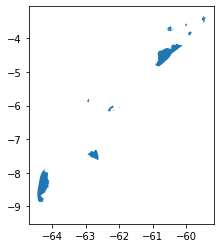

In [20]:
tis_cliped_buffer.plot()

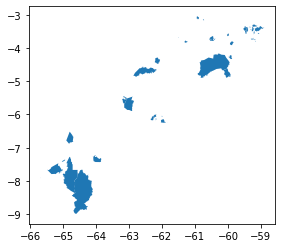

In [22]:
tis_cliped_alap.plot()

In [ ]:
ucs_cliped_alap.to_csv('ucs_cliped_alap.csv', index= False)
tis_cliped_alap.to_csv('tis_cliped_alap.csv', index= False)
assAM_cliped_alap.to_csv('assAM_cliped_alap.csv', index= False)
assRO_cliped_alap.to_csv('assRO_cliped_alap.csv', index= False)
municipios_alap.to_csv('municipios_cliped_alap.csv', index= False)

ucs_cliped_buffer.to_csv('ucs_cliped_buffer.csv', index= False)
tis_cliped_buffer.to_csv('tis_cliped_buffer.csv', index= False)
assAM_cliped_buffer.to_csv('assAM_cliped_buffer.csv', index= False)
assRO_cliped_buffer.to_csv('assRO_cliped_buffer.csv', index= False)

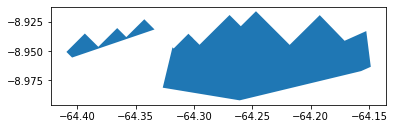

In [ ]:
assRO_cliped_alap.plot()

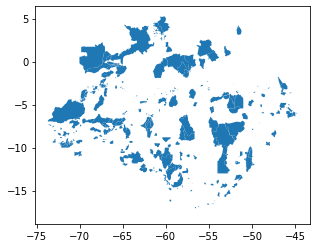

In [23]:
tis_pd.plot()

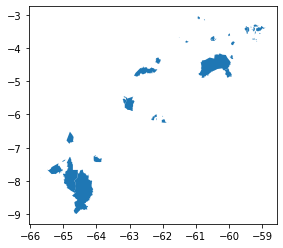

In [ ]:
tis_cliped = gpd.clip(tis_pd, alap_pd)
tis_cliped.plot()